In [1]:
import gzip, pickle
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch.nn import functional as F
import nibabel as nib
from neurovlm.data import data_dir
from neurovlm.models import Specter
from neurovlm.retrieval_resources import (
    _load_autoencoder, _proj_head_image_infonce, _proj_head_text_infonce, _load_masker
)

In [2]:
specter = Specter("allenai/specter2_aug2023refresh", adapter="adhoc_query")
proj_head_text = _proj_head_text_infonce()
proj_head_image = _proj_head_image_infonce()
autoencoder = _load_autoencoder()
masker = _load_masker()

There are adapters available but none are activated for the forward pass.


In [9]:
regions_map = {
    "Visual": [
        "Primary visual cortex",
        "Extrastriate visual cortex",
        "Lateral occipital cortex",
        "Fusiform gyrus",
        "Ventral occipitotemporal cortex",
        "Middle temporal visual area",
        "Lateral temporal-occipital",
        "Intraparietal visual",
        "Dorsal occipital-parietal"
    ],
    "Motor": [
        "Primary motor cortex",
        "Primary somatosensory cortex",
        "Premotor cortex",
        "Supplementary motor area",
        "Paracentral lobule",
        "Cerebellum",
        "Basal ganglia",
        "Thalamus"
    ],
    "Auditory": [
        "Primary auditory cortex",
        "Planum temporale",
        "Planum polare",
        "Superior temporal gyrus",
        "Superior temporal sulcus",
        "Insula",
    ],
    "Language": [
        "Inferior frontal gyrus",
        "Posterior superior temporal gyrus",
        "Middle temporal gyrus",
        "Anterior temporal lobe",
        "Angular gyrus",
        "Supramarginal gyrus",
    ],
    "Attention": [
        "Intraparietal sulcus",
        "Superior parietal lobule (dorsal)",
        "Frontal eye fields",
        "Superior frontal",
        "Temporoparietal junction",
        "Ventral frontal cortex",
        "Precuneus",
        "Parietal midline"
    ],
    "Frontoparietal Control": [
        "Dorsolateral prefrontal cortex",
        "Inferior frontal sulcus",
        "Lateral PFC",
        "Anterior prefrontal",
        "Inferior parietal lobule",
        "Intraparietal sulcus",
        "Lateral temporal cortex",
    ],
    "Cingulo-Opercular": [
        "Dorsal anterior cingulate cortex (dACC)",
        "Medial superior frontal cortex",
        "Anterior insula",
        "Frontal operculum",
        "Anterior prefrontal",
        "Anterior midline",
        "Thalamus",
    ],
    "Default Mode": [
        "Medial prefrontal cortex (mPFC)",
        "Posterior cingulate cortex",
        "Precuneus",
        "Angular gyrus",
        "Lateral inferior parietal cortex",
        "Lateral temporal cortex",
        "Retrosplenial",
        "Posterior midline regions",
        "Hippocampal formation",
    ],
    "Limbic Affective": [
        "Orbitofrontal cortex (medial & lateral OFC)",
        "Ventromedial prefrontal cortex (vmPFC)",
        "Temporal pole",
        "Anterior temporal cortex",
        "Amygdala",
        "Ventral striatum",
        "Nucleus accumbens",
        "Subgenual",
        "Ventral anterior cingulate"
    ],
    "Medial Temporal Lobe": [
        "Hippocampus",
        "Entorhinal cortex",
        "Parahippocampal cortex",
        "Perirhinal cortex",
        "Retrosplenial cortex",
        "Posterior cingulate cortex",
        "Posterior medial regions"
    ],
}

cognition_map = {
    "Visual": [
        "Visual perception",
        "Object recognition",
        "Face processing",
        "Scene processing",
        "Motion perception",
        "Visuospatial processing",
        "Visual attention",
    ],
    "Somatomotor": [
        "Voluntary movement execution",
        "Motor planning",
        "Somatosensory processing",
        "Touch",
        "Pain",
        "Temperature",
        "Proprioception",
        "Sensorimotor integration",
        "Motor learning",
        "Motor coordination"
    ],
    "Auditory": [
        "Auditory perception",
        "Pitch processing",
        "Sound localization",
        "Speech-sound processing",
        "Music perception",
    ],
    "Language": [
        "Speech comprehension",
        "Speech production",
        "Syntax processing",
        "Semantic processing",
        "Reading",
        "Lexical access",
        "Phonological processing",
    ],
    "Attention": [
        "Selective attention",
        "Spatial orienting",
        "Sustained attention",
        "Top-down attentional control",
        "Bottom-up reorienting"
    ],
    "Frontoparietal Control": [
        "Executive control",
        "Working memory",
        "Cognitive flexibility",
        "Task switching",
        "Rule/goal representation",
        "Decision making",
        "Planning",
        "Adaptive control",
    ],
    "Cingulo-Opercular": [
        "Salience detection ",
        "Performance monitoring",
        "Error detection",
        "Stable task-set maintenance",
        "Sustained control",
        "Autonomic coordination",
        "Interoception"
    ],
    "Default Mode": [
        "Self-referential thought",
        "Mind-wandering",
        "Spontaneous thought",
        "Autobiographical memory",
        "Future thinking",
        "Social cognition",
        "Theory of mind"
    ],
    "Limbic Affective": [
        "Emotion processing",
        "Affect regulation",
        "Reward valuation",
        "Motivation",
        "Approach-avoidance",
        "Social-emotional appraisal",
    ],
    "Medial Temporal Lobe": [
        "Episodic memory",
        "Encoding",
        "Retrieval",
        "Relational memory",
        "Associative memory",
        "Context binding",
        "Spatial navigation",
        "Memory consolidation",
    ],
}
label_map = [
 ('VIS-P', 'unknown'), # this is a precuneus mask
 ('CG-OP', 'cingulo_opercular'),
 ('DN-B', 'default_mode'),
 ('SMOT-B', 'motor'),
 ('AUD', 'auditory'),
 ('PM-PPr', 'motor'),
 ('dATN-B', 'attention'),
 ('SMOT-A', 'motor'),
 ('LANG', 'language'),
 ('FPN-B', 'frontoparietal_control'),
 ('FPN-A', 'frontoparietal_control'),
 ('dATN-A', 'attention'),
 ('VIS-C', 'visual'),
 ('SAL/PMN', 'cingulo_opercular'),
 ('DN-A', 'default_mode'),
 ('NONE', 'unknown'),
 ('Visual1', 'visual'),
 ('Visual2', 'visual'),
 ('Somatomotor', 'motor'),
 ('CingOperc', 'cingulo_opercular'),
 ('DorsAttn', 'attention'),
 ('Language', 'language'),
 ('FrontPar', 'frontoparietal_control'),
 ('Auditory', 'auditory'),
 ('Default', 'default_mode'),
 ('PostMulti', 'unknown'),
 ('VentMulti', 'unknown'),
 ('OrbitAffective', 'unknown'),
 ('Emo/Interoception1', 'unknown'),
 ('Emo/Interoception2', 'unknown'),
 ('Emo/Interoception3', 'unknown'),
 ('Emo/Interoception4', 'unknown'),
 ('Mot/Visspatial1', 'motor'),
 ('Mot/Visspatial2', 'motor'),
 ('Mot/Visspatial3', 'motor'),
 ('Mot/Visspatial4', 'motor'),
 ('Visual1', 'visual'),
 ('Visual2', 'visual'),
 ('Visual3', 'visual'),
 ('DivergentCog1', 'unknown'),
 ('DivergentCog3', 'unknown'),
 ('DivergentCog4', 'unknown'),
 ('DivergentCog5', 'unknown'),
 ('DivergentCog6', 'unknown'),
 ('medial frontal', 'frontoparietal_control'),
 ('frontoparietal', 'frontoparietal_control'),
 ('default mode', 'default_mode'),
 ('motor cortex', 'motor'),
 ('visual A', 'visual'),
 ('visual B', 'visual'),
 ('visual association', 'visual'),
 ('subcortical cerebellum', 'unknown'),
 ('AntSal', 'cingulo_opercular'),
 ('Auditory', 'auditory'),
 ('DorsalDMN', 'default_mode'),
 ('HighVisual', 'visual'),
 ('Language', 'language'),
 ('LECN', 'frontoparietal_control'),
 ('PostSal', 'cingulo_opercular'),
 ('Precuneus', 'default_mode'),
 ('PrimVisual', 'visual'),
 ('RECN', 'frontoparietal_control'),
 ('Sensorimotor', 'motor'),
 ('VentralDMN', 'default_mode'),
 ('Visuospatial', 'unknown'),
 ('Default', 'default_mode'),
 ('LatVis', 'visual'),
 ('FrontPar', 'frontoparietal_control'),
 ('MedVis', 'visual'),
 ('DorsAttn', 'attention'),
 ('Premotor', 'motor'),
 ('Language', 'language'),
 ('Salience', 'cingulo_opercular'),
 ('CingOperc', 'cingulo_opercular'),
 ('HandSM', 'motor'),
 ('FaceSM', 'motor'),
 ('Auditory', 'auditory'),
 ('AntMTL', 'unknown'),
 ('PostMTL', 'unknown'),
 ('ParMemory', 'unknown'),
 ('Context', 'unknown'),
 ('FootSM', 'motor'),
 ('Visual', 'visual'),
 ('VentAttn', 'unknown'), # focus on dorsal attention 
 ('DorsalSM', 'motor'),
 ('VentralSM', 'motor'),
 ('MedPar', 'default_mode'),
 ('ParOcc', 'visual'),
 ('SCAN', 'frontoparietal_control'),
 ('Cingulo-Opercular', 'cingulo_opercular'),
 ('Effector-hand', 'motor'),
 ('Effector-mouth', 'motor'),
 ('Effector-foot', 'motor'),
 ('SM', 'motor'),
 ('LateralSM', 'motor'),
 ('ResponseOneHanded(1RESP)', 'motor'),
 ('ResponseTwoHanded(2RESP)', 'motor'),
 ('AuditoryAttentionResponse(AAR)', 'auditory'),
 ('AuditoryPrimarySensory(AUD)', 'auditory'),
 ('DMNNovel(DMNA)', 'default_mode'),
 ('DMNTraditional(DMNB)', 'default_mode'),
 ('FocusOnVisualFeatures(FoVF)', 'visual'),
 ('Initiation(INIT)', 'unknown'),
 ('Language(LN)', 'language'),
 ('MAIN', 'unknown'),
 ('MultipleDemand(MDN)', 'frontoparietal_control'),
 ('Re-evaluation(RE-EV)', 'frontoparietal_control'),
 ('DefaultA', 'default_mode'),
 ('DefaultB', 'default_mode'),
 ('DefaultC', 'default_mode'),
 ('Language', 'language'),
 ('ContA', 'frontoparietal_control'),
 ('ContB', 'frontoparietal_control'),
 ('ContC', 'frontoparietal_control'),
 ('SalVenAttnA', 'cingulo_opercular'),
 ('SalVenAttnB', 'cingulo_opercular'),
 ('DorsAttnA', 'attention'),
 ('DorsAttnB', 'attention'),
 ('Aud', 'auditory'),
 ('SomMotA', 'motor'),
 ('SomMotB', 'motor'),
 ('VisualA', 'visual'),
 ('VisualB', 'visual'),
 ('VisualC', 'visual'),
 ('TempPar', 'frontoparietal_control'),
 ('LimbicA', 'unknown'), # these are dlmpc and temporal lobe
 ('LimbicB', 'unknown'),
 ('SalVentAttnB', 'cingulo_opercular'),
 ('SalVentAttnA', 'cingulo_opercular'),
 ('VisPeri', 'visual'),
 ('VisCent', 'visual'),
 ('SomatomotorA', 'motor'),
 ('SomatomotorB', 'motor'),
 ('Sal/VenAttnA', 'cingulo_opercular'),
 ('Sal/VenAttnB', 'cingulo_opercular'),
 ('ControlC', 'frontoparietal_control'),
 ('ControlA', 'frontoparietal_control'),
 ('ControlB', 'frontoparietal_control'),
 ('Visual', 'visual'),
 ('Somatomotor', 'motor'),
 ('DorsAttn', 'attention'),
 ('Sal/VenAttn', 'cingulo_opercular'),
 ('Limbic', 'unknown'),
 ('Control', 'frontoparietal_control'),
 ('Default', 'default_mode')]

In [10]:
network_labels = list(regions_map.keys())
network_labels = [i for i in network_labels if i != "Limbic Affective"]
region_labels = np.unique(sum(list(regions_map.values()), [])).tolist()
cognition_labels =  np.unique(sum(list(cognition_map.values()), [])).tolist()

In [11]:
with torch.no_grad():
    text_networks_emb = F.normalize(specter(network_labels), dim=1)
    text_networks_emb = F.normalize(proj_head_text(text_networks_emb), dim=1)

    text_regions_emb = F.normalize(specter(region_labels), dim=1)
    text_regions_emb = F.normalize(proj_head_text(text_regions_emb), dim=1)

    text_cognition_emb = F.normalize(specter(cognition_labels), dim=1)
    text_cognition_emb = F.normalize(proj_head_text(text_cognition_emb), dim=1)

In [12]:
# Load network atlases
with gzip.open(data_dir / "networks_arrays.pkl.gz", "rb") as f:
    networks = pickle.load(f)

network_imgs = []
for k in networks.keys():
    for a in networks[k].keys():
        network_imgs.append((k, a, nib.Nifti1Image(networks[k][a]["array"], affine=networks[k][a]["affine"])))

networks = [i for i in network_imgs if i[0] not in ["UKBICA", "HCPICA"]]

networks_embed = F.normalize(proj_head_image(torch.load(data_dir / "networks_emb.pt")).detach(), dim=1)

In [13]:
network_labels = np.array(network_labels)
region_labels = np.array(region_labels)
cognition_labels = np.array(cognition_labels)

sim_networks = networks_embed @ text_networks_emb.T
sim_regions = networks_embed @ text_regions_emb.T
sim_cognition = networks_embed @ text_cognition_emb.T

inds_networks = sim_networks.argsort(dim=1, descending=True)[:, :5]
inds_regions = sim_regions.argsort(dim=1, descending=True)[:, :5]
inds_cognition = sim_cognition.argsort(dim=1, descending=True)[:, :5]

results_networks = [(networks[idx][1], network_labels[i], sim_networks[idx, i], networks[idx][2]) for idx, i in enumerate(inds_networks.numpy())]
results_regions = [(networks[idx][1], region_labels[i], sim_regions[idx, i]) for idx, i in enumerate(inds_regions.numpy())]
results_cognition = [(networks[idx][1], cognition_labels[i], sim_cognition[idx, i]) for idx, i in enumerate(inds_cognition.numpy())]

In [14]:
key_map_inv = {
    'Visual':'visual',
    'Motor': 'motor',
    'Auditory': 'auditory',
    'Language': 'language',
    'Attention': 'attention',
    'Frontoparietal Control': 'frontoparietal_control',
    'Cingulo-Opercular': 'cingulo_opercular',
    'Default Mode': 'default_mode'
}
key_map = {v: k for k, v in key_map_inv.items()}

top = [key_map_inv[i[1][0]] for i in results_networks if i[1][0] in key_map.values()]

mask = np.array([i[1] in key_map.keys() for i in label_map])
mask[[45, 61, 108, 109, 63, 14]] = False
df = pd.DataFrame(dict(
    label=np.array([i[1] for i, j in zip(label_map, mask) if j]),
    label_re=np.array([key_map[i[1]] for i, j in zip(label_map, mask) if j]),
    top=[key_map_inv[i[1][0]] for i, j in zip(results_networks, mask) if j],
    score=[i[2][0] for i, j in zip(results_networks, mask) if j],
    score_min=[i[2][-1] for i, j in zip(results_networks, mask) if j]
), index=np.arange(len(mask))[mask])
# df = df[df["label"] == df["top"]].loc[lambda d: d.groupby("label")["score"].idxmax()]

df = df[df.index.isin([69, 23, 127, 107, 137, 21, 94, 17])]
df

,label,label_re,top,score,score_min
17,visual,Visual,visual,tensor(0.4388),tensor(0.0281)
21,language,Language,language,tensor(0.3044),tensor(0.0180)
23,auditory,Auditory,auditory,tensor(0.4458),tensor(-0.0164)
69,attention,Attention,attention,tensor(0.2827),tensor(0.0345)
94,motor,Motor,motor,tensor(0.3509),tensor(0.0152)
107,default_mode,Default Mode,default_mode,tensor(0.3881),tensor(-0.2188)
127,cingulo_opercular,Cingulo-Opercular,cingulo_opercular,tensor(0.2069),tensor(-0.0836)
137,frontoparietal_control,Frontoparietal Control,frontoparietal_control,tensor(0.1040),tensor(-0.1155)


In [153]:
# df = df[df["label"] == df["top"]]
# df[df["label"] == "cingulo_opercular"]

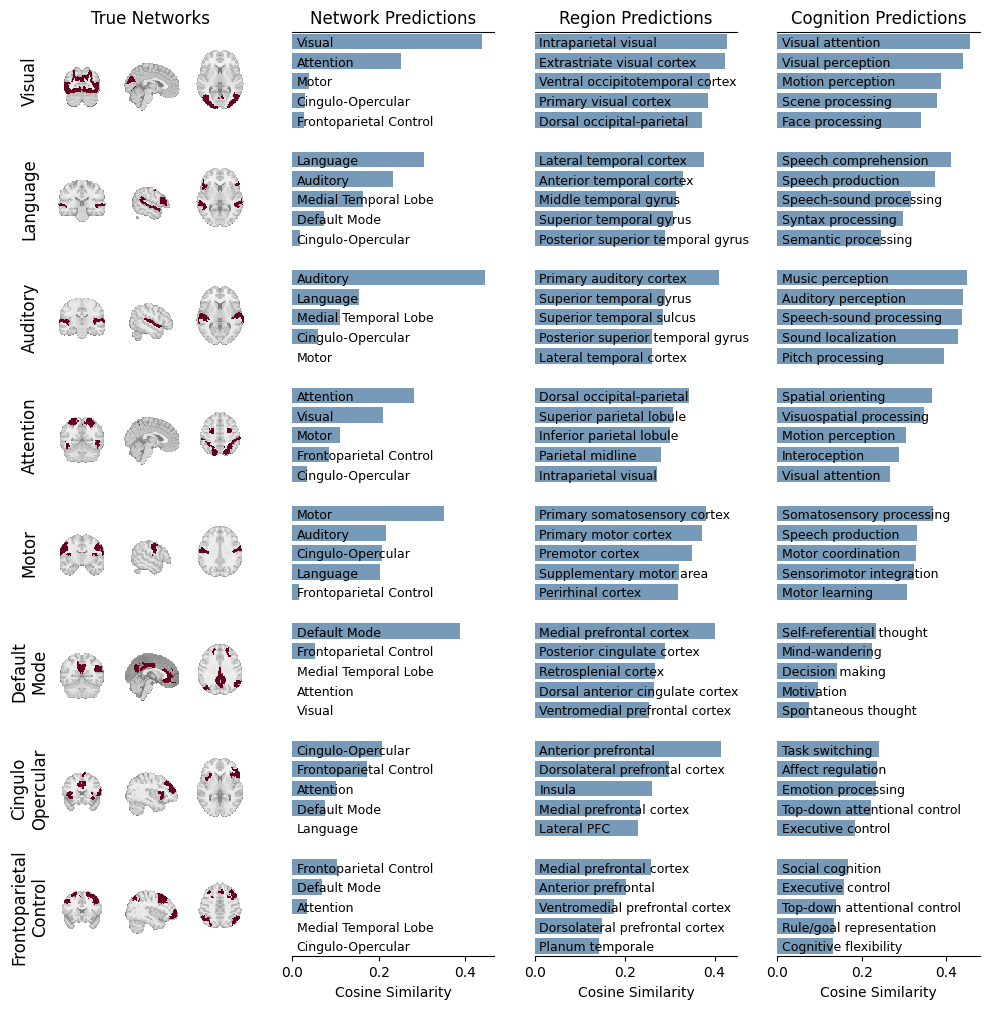

In [15]:
fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(12, 12), sharex="col")

def bars(results, lab, i_ax=1):
    
    i = 0
    
    for ax, r in zip(axes[:, i_ax], results):
        _labels = [i.split(" (")[0] for i in r[1]]
        _sim = r[2]
        _sim[_sim < 0] = 0.
        
        # Create color palette based on values
        colors = ['red' if val < 0 else 'steelblue' for val in _sim]
        y_vals = range(0, len(_sim))
        
        sns.barplot(y=y_vals, x=_sim, orient="h", ax=ax, 
                    hue=y_vals, palette=colors, alpha=0.8, legend=False)
        
        for patch, _label in zip(ax.patches, _labels):
            y0 = patch.get_y()
            h = patch.get_height()
            y_top = y0 + h
            
            ax.annotate(
                _label,
                (0.01, y_top),
                xytext=(0, 0),
                textcoords="offset points",
                ha="left",
                va="bottom",
                fontsize=9,
            )
        if i == 0:
             ax.spines[['bottom', 'right', 'left']].set_visible(False)
             ax.yaxis.set_visible(False)
             ax.xaxis.set_visible(False)
             ax.set_title(lab)
        elif i < 7:
            ax.axis("off")
        else:
            ax.spines[['top', 'right', 'left']].set_visible(False)
            ax.yaxis.set_visible(False)
            ax.set_xlabel("Cosine Similarity")  # Changed from set_ylabel
        i += 1

# Barplots
bars([i for idx, i in enumerate(results_networks) if idx in df.index.values], "Network Predictions", i_ax=1)
bars([i for idx, i in enumerate(results_regions) if idx in df.index.values], "Region Predictions", i_ax=2)
bars([i for idx, i in enumerate(results_cognition) if idx in df.index.values], "Cognition Predictions", i_ax=3)

# Network images
true = [i[1][0] for idx, i in enumerate(results_networks) if idx in df.index.values]
imgs = [i[-1] for idx, i in enumerate(results_networks) if idx in df.index.values]

cut_coords = {str(k): None for k in true}
cut_coords["Cingulo-Opercular"] = [-38, 18, 2]
cut_coords["Default Mode"] = [0, -56, 34]

first = True
for ax, t, img in zip(axes[:, 0], true, imgs):
    
    coords = cut_coords[t]
    plot_stat_map(img, colorbar=False, draw_cross=False, annotate=False, axes=ax, cut_coords=coords)
    ax.set_ylabel(
        "\n".join(("\n".join(t.split(" "))).split("-"))
    )
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(
        -0.1, 0.5, 
        "\n".join(("\n".join(t.split(" "))).split("-")),
        transform=ax.transAxes,
        rotation=90,
        verticalalignment='center',
        horizontalalignment='center',
        fontsize=12
    )
    if first:
        ax.set_title("True Networks")
    first = False
plt.savefig(data_dir / "clip.svg", dpi=300)

In [16]:
df.to_csv(data_dir / "network_examples.csv")
torch.save(dict(label=true, img=imgs), data_dir / "network_examples.pt")